### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [9]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time

In [2]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D

In [3]:
from models import *

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

In [4]:
#Invariants
ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
ORDER_LIST=list(ORDER_KEY)

These are helper functions to clean and process data. 

In [5]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

Import the alignment data:

In [6]:
# data=pdataframe_from_alignment_file("PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m",50000)
data=pd.read_csv("sarkisyan.csv")
print ("number of data points: ",len(data))
data_set_size=len(data)
data.head()

number of data points:  51715


,sequence,quantitative_function
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.000000
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007230
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007231
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007295
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.995593


Let's see how long the sequence is

In [7]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 238
sample sequence:  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


We are only really interested in the columns that do align. This means that for every column that we include, at least 50% of sequences are not gaps. Note that this threshold is imposed by the alignment parameters loaded above. So let's make a column for that. Meanwhile, we keep track of the indices that did align.

In [10]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,sequence,quantitative_function,seq
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.000000,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007230,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007231,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.007295,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.995593,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


Let's see how many columns remained. 

In [11]:
print ("pruned sequence length:", len(data.iloc[0]["seq"]))
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])

pruned sequence length: 238


A few optional lines of code to run. Printing indices, and deleting the sequence column so that it doesn't stay in memory for no reason. 

Next we translate the sequence into a one hot encoding and shape the input sequences into a m*n matrix. Here m is the number of the data points and $n=$ alphbet size $\times$ sequence length.

In [12]:
#Encode training data in one_hot vectors
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot),len(training_data_one_hot[0]),len(training_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.T.flatten())) for sample in training_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)

51715 24 238
(51715, 5712)


That takes care of the training data. But we also need to test our model on something. Thankfully, some neat experiments have been done to actually measure the effects of change in a sequence on the performance of the protein. We load this data next (because we want to make use of this test data to evaluate our performance at the end of each epoch). 

In [13]:
training_data.shape

(51715, 5712)

## Exploring the data

In [15]:
def seqDist(seq1, seq2):
    return np.sum(np.array(list(seq1)) != np.array(list(seq2)))

In [41]:
distanceMatrix = np.zeros([len(data), len(data)])

In [45]:
#takes so long
for i in range(len(data)):
    for j in range(len(data)):
        distanceMatrix[i][j] = seqDist(data['sequence'][i], data['sequence'][j])
        print (i)

KeyboardInterrupt: 

In [47]:
file = open("sequences.fasta", "w")
for i in range(len(data)):
    file.write((">"+str(i)+"\n"))
    file.write(data['sequence'][i])
    file.write("\n")
    
file.close()

In [16]:
distance_from_0 = np.zeros([len(data)])
for i in range(len(data)):
    distance_from_0[i] = seqDist(data['sequence'][0], data['sequence'][i])

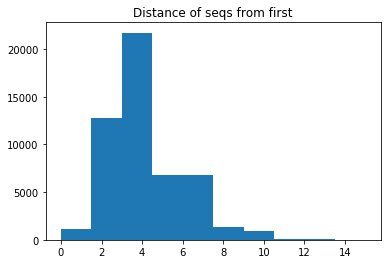

In [20]:
plt.hist(distance_from_0)
plt.title("Distance of seqs from first")
plt.show()

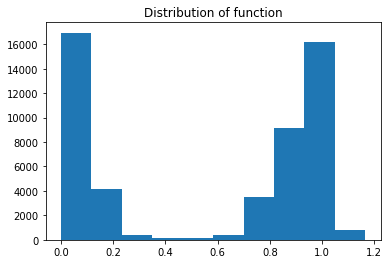

In [21]:
plt.hist(data['quantitative_function'])
plt.title("Distribution of function")
plt.show()

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=2)
pca.fit(training_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
PCA_data_2dim = pca.transform(training_data)

In [28]:
PCA_data_2dim.transpose(1, 0)

array([[-0.03385088, -0.03257317, -0.00423299, ..., -0.16219301,
        -0.04248524, -0.23336189],
       [-0.02218666, -0.01939376, -0.16224682, ..., -0.16681947,
        -0.13729807,  0.08953746]])

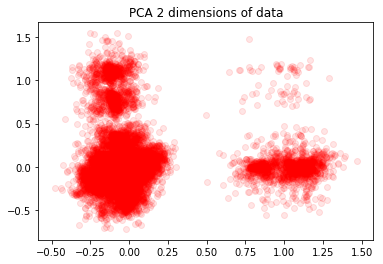

In [35]:
plt.scatter(PCA_data_2dim.transpose(1, 0)[0], PCA_data_2dim.transpose(1, 0)[1], alpha=0.1, color='r')
plt.title("PCA 2 dimensions of data")
plt.show()

## Baseline One-hot model

In [12]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=5)
pca.fit(training_data)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
PCA_training_data = pca.transform(training_data)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [27]:
#Classification on training data
data['function'] = data['quantitative_function'] > 0.5
X_train, X_test, y_train, y_test = train_test_split(training_data, data['function'], 
                                                   test_size = 0.3, random_state=10)

naiveClf = RandomForestClassifier()
naiveClf.fit(X_train, y_train)
naiveClf.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9205285207863358

In [29]:
X_train, X_test, y_train, y_test = train_test_split(training_data, data['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7445187384932194

In [30]:
X_train, X_test, y_train, y_test = train_test_split(PCA_training_data, data['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.029654035528665856

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [36]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [37]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [38]:
PRUNED_SEQ_LENGTH

238

In [45]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 2
intermediate_dim = 250
nb_epoch = 10
epsilon_std = 1.0
np.random.seed(42)  

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
#     print ("xent loss: ", xent_loss)
#     print ("KL loss: ", kl_loss)
    return (xent_loss + kl_loss)

# #Encoding Layers
# x = Input(batch_shape=(batch_size, original_dim))
# h = Dense(intermediate_dim,activation="elu")(x)
# h= Dropout(0.7)(h)
# h = Dense(intermediate_dim, activation='elu')(h)
# h=BatchNormalization(mode=0)(h)
# h = Dense(intermediate_dim, activation='elu')(h)

# #Latent layers
# z_mean=Dense(latent_dim)(h)
# z_log_var=Dense(latent_dim)(h)
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# #Decoding layers 

# decoder_1= Dense(intermediate_dim, activation='elu')
# decoder_2=Dense(intermediate_dim, activation='elu')
# decoder_2d=Dropout(0.7)
# decoder_3=Dense(intermediate_dim, activation='elu')
# decoder_out=Dense(output_dim, activation='sigmoid')
# x_decoded_mean = decoder_out(decoder_3(decoder_2d(decoder_2(decoder_1(z)))))

# vae = Model(x, x_decoded_mean)

# #Potentially better results, but requires further hyperparameter tuning
# #optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.001, decay=0.0, nesterov=False,clipvalue=0.05)
# vae.compile(optimizer="adam", loss=vae_loss,metrics=["categorical_accuracy","fmeasure","top_k_categorical_accuracy"])

And run it through our training data.

In [46]:
len(range(0, 300)[:20])

20

In [47]:
training_size = 51700 #so batchingw orks
x_train=training_data[:51700] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# spearman_measure=rho_vs_mutants(test_data_plus,batch_size*int(len(test_data_plus)/batch_size),len(ORDER_LIST),PRUNED_SEQ_LENGTH)

In [48]:
vae_type = 'full'

In [49]:
if vae_type == 'full':
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [100,100]
    kernels_enc = [6,10]
    out_lin_enc = [200,100]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [200,250]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1),
                                nn.ELU(),
                                nn.MaxPool1d(4,padding=0),
                                nn.ZeroPad2d((2,3,0,0)),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1),
                                nn.ELU(),
                                nn.MaxPool1d(3,padding=0)])
    
    enc_view = 100*5
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
#     hid_sizes = [100,100]
    
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),1,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
    layers_post_rec_enc = nn.ModuleList([nn.Linear(4,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()])
    
    
    layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
                                        nn.Dropout(dropout_dec[0]),
                                        nn.ELU()])
    # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
    layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
    layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])
    
    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])

In [50]:
if vae_type == 'full':
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.10058027079)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH * len(ORDER_LIST))

        train = torch.Tensor(train)

        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,layers_pre_rec_dec,layers_dec,layers_post_rec_dec)
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
#         train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

Epoch 0 | Training Loss: 626.3097534179688, Training Accuracy: 0.9837108520827685, Validation Loss: 657.1267700195312, Validation Accuracy: 0.983670814479638
Epoch 1 | Training Loss: 620.5199584960938, Training Accuracy: 0.9837108520827685, Validation Loss: 646.1626586914062, Validation Accuracy: 0.983670814479638
Epoch 2 | Training Loss: 576.0095825195312, Training Accuracy: 0.9837108520827685, Validation Loss: 610.8906860351562, Validation Accuracy: 0.983670814479638


KeyboardInterrupt: 

Let's explore the latent space

In [51]:
fit_xtrain = model(torch.Tensor(x_train)).detach()
z_means = model.z_mean.detach()

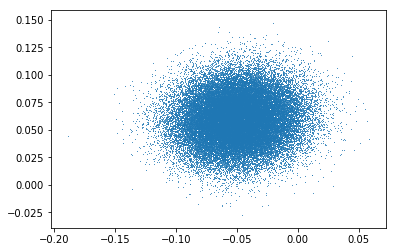

In [52]:
transposed_zmeans = np.array(z_means).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [53]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means)
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

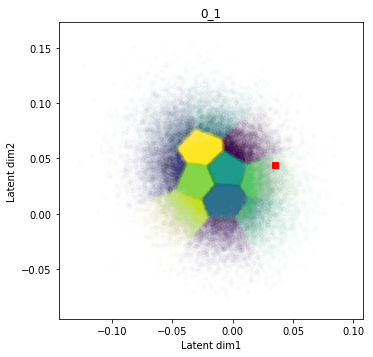

In [28]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.01,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


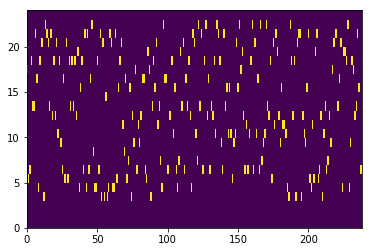

In [29]:
plt.pcolor(x_train[0].reshape(238, 24).transpose(1, 0))
plt.show()

# Training a classifier over the latent space

In [30]:
fit_total = model(torch.Tensor(training_data)).detach()
latent_data = model.z_mean.detach()

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), data['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

In [42]:
latentReg = RandomForestRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-0.2316601233767477

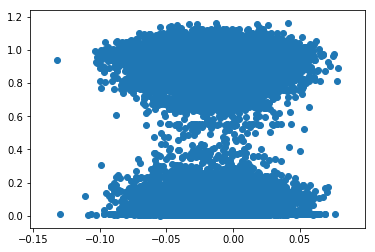

In [63]:
plt.scatter(X_train[:,0], y_train)
plt.show()

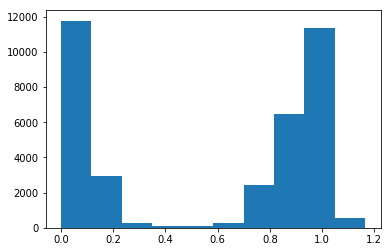

In [38]:
plt.hist(y_train)
plt.show()

In [54]:
np.sum(data['function'])/len(data)

0.5817461084791646

In [45]:
data['function'] = data['quantitative_function'] > 0.5

X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), data['function'], 
                                                   test_size = 0.3, random_state=10)

latentClf = RandomForestClassifier()
latentClf.fit(X_train, y_train)
# latentReg.predict(X_test)
latentClf.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5151788591685466

In [48]:
# reshaped_fit_xtrain = fit_xtrain.reshape(len(x_train)*len(ORDER_LIST),PRUNED_SEQ_LENGTH)
m = torch.nn.Softmax()

reshaped_fit_xtrain = m(fit_xtrain.reshape(51700 * 238, 24)).reshape(51700, 238, 24).transpose(2, 1)

# m = torch.nn.Sigmoid()

# reshaped_fit_xtrain = torch.stack(list(map(m, fit_xtrain))).reshape(50000, 82, 24).transpose(2, 1)

//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [ ]:
plt.pcolor(reshaped_fit_xtrain[0])

In [ ]:
plt.pcolor(np.matmul(test_data_plus[0].reshape(digit_size, sequence_size).T, digit_wt))

In [52]:
# sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_size = batch_size*int(len(x_train)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)
x_decoded=reshaped_fit_xtrain






wt_prob=compute_log_probability(x_train[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(1,sample_size):
    digit = x_decoded[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
# print ("Spearman",spearmanr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))
# print ("Pearson", pearsonr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))

/Users/DavidKMYang/Spring2019_Harvard/Math243/VAE_protein_function/helper_tools.py:103: RuntimeWarning: divide by zero encountered in log
  log_prod_mat=np.log(prod_mat)
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plt.pcolor(test_data_plus[0].reshape(digit_size, sequence_size))

In [ ]:
plt.pcolor(digit_wt)

In [ ]:
spearmanr(fitnesses_vs_avg, fitnesses)

In [ ]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.ylabel("Fitness vs. wt")
plt.xlabel("p(x)")
plt.title(spearmanr(fitnesses_vs_wt, target_values_singles[:sample_size-1]))
plt.tight_layout()
plt.savefig("Correlation.png")
plt.show()


In [ ]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.show()

In [ ]:
plt.hist(fitnesses,bins=30)
plt.show()

In [ ]:
plt.hist(target_values_singles[:sample_size-1], bins=50)
plt.show()

We have kept track of some performance metrics, so we can follow whether the network was still improving. 